In [1]:
print("strawberry")

strawberry


In [2]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss
import torch.nn as nn

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import torch.distributions as td

from tqdm import tqdm

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [7]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [8]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [9]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [13]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

### setup model

In [20]:
in_channels = 3
out_channels = 2

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
    model_raw = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )
    
    
    optimizer_params={"lr":2e-3}
    lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [21]:
#summary(model, (1, 3, 128, 128))

In [22]:
loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [23]:
optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer = torch.optim.RMSprop
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [25]:
# model = StandardLitModelWrapper(model_raw, loss, 
#                                 logging_metric=lambda : None,
#                                 optimizer_params=optimizer_params,
#                                 lr_scheduler_params=lr_scheduler_params,
#                                 is_uq_model=False,
#                                 optimizer_constructor=optimizer,
#                                 lr_scheduler_constructor=lr_scheduler_constructor
#                                )
checkpoint="../epoch=38-step=1560.ckpt"
model = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model_raw, loss=loss, logging_metric = lambda : None)

In [26]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [27]:
#trainer.fit(model, train_dataloader, val_dataloader)

In [28]:
trainer.validate(model, val_dataloader)

Missing logger folder: lightning_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.3036971390247345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.3036971390247345}]

In [34]:
x1, y1 = next(iter(val_dataloader))

In [35]:
with torch.no_grad():
    model.eval()
    y_hat = model(x1.to(model.device))

In [36]:
y1.shape, y_hat.shape, x1.shape

(torch.Size([64, 224, 160]),
 torch.Size([64, 2, 224, 160]),
 torch.Size([64, 3, 224, 160]))

In [37]:
torch.max(x1)

tensor(16.0128)

In [38]:
dice_loss(y_hat, y1)


tensor(0.3922)

In [39]:
TverskyLoss(beta=0.7)(y_hat, y1)

tensor(0.3963)

In [40]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator)/ (denominator + 1e-8)) / (s0-ignores) # s0

In [41]:
def slice_dice(y_hat, y_true):
    # print(y_hat.shape)
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    # print(y_hat.shape)
    # print(y_true.shape)
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [42]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [43]:
dice(y_hat, y1)

tensor(0.6357)

In [44]:
actual_dice(y_hat, y1)

tensor(0.3387)

tensor(0.3665)


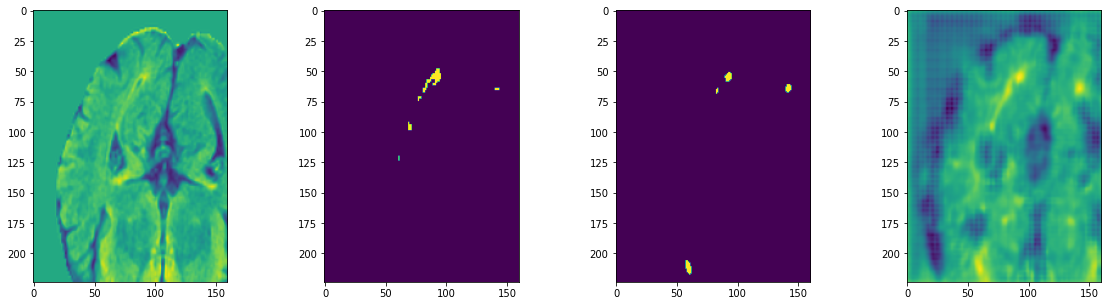

In [45]:
ind = 49
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:])
plt.subplot(1,4,2)
plt.imshow(y1[ind])
plt.subplot(1,4,3)
plt.imshow(y_hat.softmax(dim=1).argmax(dim=1)[ind])
plt.subplot(1,4,4)
plt.imshow(y_hat[ind][1])
print(slice_dice(y_hat[ind], y1[ind]))
plt.show()

### Building the epinet


I will use for the learnable prior a small convolutional unet.

for the non learnable prior, I use the same model as the learnable prior, with the same initialization, but without training the weights,
in combination with a small ensemble of randomly initiallyised non trainable unets that take in the input directly and have their output multiplied by the sampled noise vector. Nice.

In [36]:
def get_simpleblock(ins, outs, frac=1):
    return nn.Sequential(
        nn.Conv2d(ins, 8//frac, 3, stride=2, padding=1),
        nn.Conv2d(8//frac, 16//frac, 3, stride=2, padding=1),
        nn.Conv2d(16//frac, 32//frac, 3, stride=2, padding=1),
        nn.ConvTranspose2d(32//frac,16//frac,3, stride=2, output_padding=1, padding=1),
        nn.ConvTranspose2d(16//frac,8//frac,3, stride=2, output_padding=1, padding=1),
        nn.ConvTranspose2d(8//frac,outs, 3, stride=2, output_padding=1, padding=1)
    )

In [47]:
priorblock_in = get_simpleblock(in_channels, out_channels)
epiblock_out = get_simpleblock(in_channels * 2, out_channels)

In [48]:
summary(priorblock_in, (1,3, 224, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 8, 112, 80]           224
├─Conv2d: 1-2                            [1, 16, 56, 40]           1,168
├─Conv2d: 1-3                            [1, 32, 28, 20]           4,640
├─ConvTranspose2d: 1-4                   [1, 16, 56, 40]           4,624
├─ConvTranspose2d: 1-5                   [1, 8, 112, 80]           1,160
├─ConvTranspose2d: 1-6                   [1, 2, 224, 160]          146
Total params: 11,962
Trainable params: 11,962
Non-trainable params: 0
Total mult-adds (M): 33.21
Input size (MB): 0.43
Forward/backward pass size (MB): 2.44
Params size (MB): 0.05
Estimated Total Size (MB): 2.92

In [30]:
class ENN(nn.Module):
    def __init__(self, base_model, ensembles=2, prior_mix_ratio = 0.5, alpha = 1., mc_samples=10):
        super().__init__()
        self.base_model = model
        self.learnable = get_simpleblock(in_channels + (out_channels * 2), out_channels, frac=1)
        self.prior_fixed = get_simpleblock(in_channels + (out_channels * 2), out_channels, frac=1)
        self.prior_ensemble = nn.ModuleList([get_simpleblock(in_channels, out_channels, frac=2) for _ in range(ensembles)])
        self.num_ensembles = ensembles
        self.prior_mix_ratio = prior_mix_ratio
        self.alpha = alpha
        self.mc_samples = mc_samples
        assert 0 <= prior_mix_ratio <= 1
        
        # set prior fixed and learnable to have same initialization
        self.prior_fixed.load_state_dict(self.learnable.state_dict())
        
        # set all prior models to be non trainable
        for p in self.prior_fixed.parameters():
            p.requires_grad = False
        for m in self.prior_ensemble:
            for p in m.parameters():
                p.requires_grad = False
        
        """
        implement the stop gradient
        implement the loss function
        """
        
    def forward(self, x):
        original = self.base_model(x)
        
        # with torch.no_grad():
        self.base_model.eval()
        base_learnable = self.base_model(x)
        self.base_model.train()
        base = base_learnable.detach()
        
        outs = []
        for _ in range(self.mc_samples):
            z = torch.randn(base.shape).to(base.device) * 1.
            epi_learnable_input = torch.cat([base, x, z], dim=1)

            learnable_out = self.learnable(epi_learnable_input)
            prior_fixed_out = self.prior_fixed(epi_learnable_input)

            prior_ensemble_out = torch.zeros(base.shape).to(base.device)
            for i, m in enumerate(self.prior_ensemble):
                prior_ensemble_out += m(x) * z[:,i].unsqueeze(dim=1)

            #combined_out = base_learnable + learnable_out + self.alpha * ((prior_ensemble_out * self.prior_mix_ratio) + (prior_fixed_out * (1-self.prior_mix_ratio)))
            combined_out = base + 1. * (learnable_out + self.alpha * prior_fixed_out)
            #combined_out = base_learnable + learnable_out + self.alpha * prior_ensemble_out
            outs.append(combined_out)
            
        return outs

In [50]:
#list(enn_model.model.prior_fixed.parameters())[0][0][0]

In [51]:
#list(enn_model.model.learnable.parameters())[0][0][0]

In [52]:
#list(enn_model.model.base_model.parameters())[0][0][0]

In [53]:
# for p in enn_model.model.learnable.parameters():
#     print(torch.max(p.abs()))

In [31]:
def sample_diversity(outs):
    diversity = 0
    for s1, s2 in zip(outs[1:], outs[:-1]):
        diversity += torch.nn.functional.mse_loss(s1,s2)
    return diversity / (len(outs) - 1)

In [32]:
torch.nn.functional.mse_loss

<function torch.nn.functional.mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>

In [33]:
def enn_loss(outs, target):
    loss_sum = torch.Tensor([0.]).to(target.device)
    for o in outs:
        loss_sum += loss(o, target)
    return (loss_sum / len(outs)) #- sample_diversity(outs)

In [34]:
x = torch.randn(1,2,3,4)
b = torch.randn(1,2,3,4)
torch.nn.functional.mse_loss(x, b)

tensor(1.4963)

In [37]:
enn = ENN(model)

In [38]:
#summary(enn)

In [39]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
enn_trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [40]:
optimizer_params_enn={"lr":2e-3}
lr_scheduler_params_enn={"step_size":20, "gamma":0.5}
optimizer_enn = torch.optim.Adam
lr_scheduler_constructor_enn = None
# optimizer_params_enn={"lr":2e-3, "momentum":0.6}
# optimizer_enn = torch.optim.RMSprop
# lr_scheduler_params_enn={"milestones":[10,100,200], "gamma":0.5}
# lr_scheduler_constructor_enn = torch.optim.lr_scheduler.MultiStepLR

enn_model = StandardLitModelWrapper(enn, enn_loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params_enn,
                                lr_scheduler_params=lr_scheduler_params_enn,
                                is_uq_model=False,
                                optimizer_constructor=optimizer_enn,
                                lr_scheduler_constructor=lr_scheduler_constructor_enn
                               )

#enn_checkpoint = "epinet_trained.ckpt"
#enn_model.load_state_dict(torch.load(enn_checkpoint))

In [41]:
#enn_model

In [42]:
enn_trainer.fit(enn_model, train_dataloader, val_dataloader)

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/s2208943/ipdis/Trustworthai-MRI-WMH/trustworthai/models/uq_models/initial_variants/epinet/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | ENN  | 2.8 M 
-------------------------------
2.8 M     Trainable params
18.5 K    Non-trainable params
2.8 M     Total params
11.220    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [75]:
trainer.validate(enn_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.2606741786003113
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.2606741786003113}]

In [43]:
#trainer.validate(enn_model, train_dataloader)

In [76]:
torch.save(enn_model.state_dict(), "epinet_trained_ed_domain.ckpt")

In [77]:
enn_model.load_state_dict(torch.load( "epinet_trained_ed_domain.ckpt"))

<All keys matched successfully>

In [78]:
x1, y1 = next(iter(val_dataloader))

In [79]:
with torch.no_grad():
    model.eval()
    y_hat = enn.base_model(x1.to(model.device)).cpu()
    #y_hat = model(x1.to(model.device)).cpu()
    enn.eval()
    enn_hat = enn(x1.to(model.device))
    enn_hat = [o.cpu() for o in enn_hat]

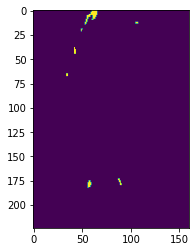

In [80]:
plt.imshow(y1[ind])

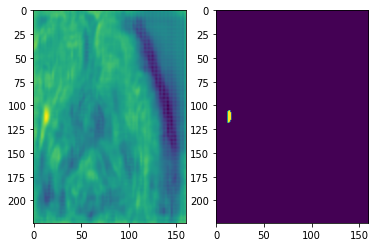

In [84]:
ind = 57
plt.subplot(1,2,1)
plt.imshow(y_hat[ind][1])
plt.subplot(1,2,2)
plt.imshow(torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)[ind])
plt.show()

In [ ]:
plt.imshow(((ent_map[ind]) * x1[ind][1]).clamp(0)); plt.colorbar()
#plt.imshow(((ent_map[ind] - exp_ent_map[ind]) * x1[ind][1]).clamp(0)); plt.colorbar()

NameError: name 'ent_map' is not defined

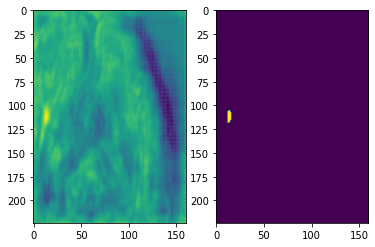

In [85]:
sample = 1
plt.subplot(1,2,1)
plt.imshow(enn_hat[sample][ind][1])
plt.subplot(1,2,2)
plt.imshow(torch.nn.functional.softmax(enn_hat[sample], dim=1).argmax(dim=1)[ind])
plt.show()

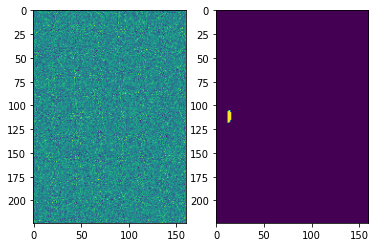

In [86]:
plt.subplot(1,2,1)
plt.imshow(enn_hat[0][ind][1] - enn_hat[1][ind][1])
plt.subplot(1,2,2)
plt.imshow(torch.nn.functional.softmax(enn_hat[sample], dim=1).argmax(dim=1)[ind])
plt.show()

In [52]:
torch.max(torch.nn.functional.softmax(enn_hat[0], dim=1) - torch.nn.functional.softmax(enn_hat[1], dim=1))

tensor(0.9234)

In [53]:
stack = torch.stack(enn_hat)
stack.shape

torch.Size([10, 64, 2, 224, 160])

In [54]:
pim = torch.mean(torch.nn.functional.softmax(stack, dim=2), dim=0)
ent_map = torch.sum(-pim * torch.log(pim+1e-30), dim=1)

In [54]:

pim = torch.mean(torch.nn.functional.softmax(stack, dim=1), dim=0)
ent_map = torch.sum(-pim * torch.log(pim+1e-30), dim=1)

In [77]:
prob_stack = torch.nn.functional.softmax(stack, dim=1+1)
exp_ent_map = torch.mean(torch.sum(-prob_stack * torch.log(prob_stack+1e-30), dim=1+1), dim=0)

In [78]:
stack.shape

torch.Size([10, 64, 2, 224, 160])

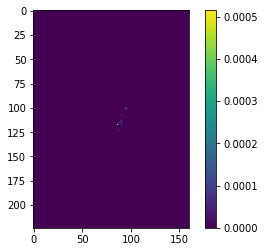

In [80]:
plt.imshow(((ent_map[ind] - exp_ent_map[ind]) * x1[ind][1])); plt.colorbar()

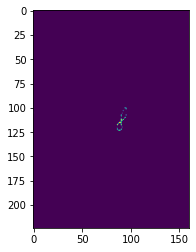

In [81]:
# ent map with brain masked out
plt.imshow(ent_map[ind] * x1[ind][1])

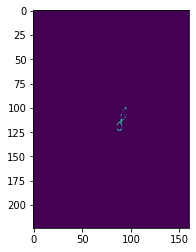

In [62]:
plt.imshow(exp_ent_map[ind] * x1[ind][1])

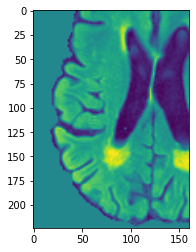

In [106]:
plt.imshow(x1[ind][0])

In [180]:
import torch
import numpy as np

"""
'However, variance is not sufficiently representative in the con-
text of multi-modal distributions.' - https://arxiv.org/pdf/1807.07356.pdf
chpt 3
"""

def samples_entropy_map(samples, 
                        p_from_mode=True,
                        threshold_preds=False,
                        preds_threshold=0.9,
                        apply_norm=False,
                        norm_func='sigmoid',
                        apply_binning=False,
                        binning_dp = 1,
                        supress_warning=False,
                        print_uniques=False,
                       ):
    """
    H(y|x) = - sum_1^M{p_hat_i_m ln(p_hat_i_m)}
    where p_hat_m is the frequency of the m-th unique value.
    
    Okay so this implies that my model results have been turned directly
    into classes which currently my model outputs are not
    
    so should I take the mode or the mean..?
    
    samples: the different samples taken for the input batch
    p_from_mode: the different smaples taken for the input batch
    """
    # i.e should be number of classes, but could also represent
    # probability of being class 1, so I need to decide what I am rrepresenting
    # the former makes this function easier and fits mroe nicely with the 'semantic segmentation idea'.
    # but ideally the model outputs a probability... hmm should clear this up with them.
    
    if threshold_preds:
        if not supress_warning:
            print("warning, thresholding only valid for binary class problem")
        samples = samples > preds_threshold
        
    if apply_binning:
        if not supress_warning:
            print("warning, binning should only be applied where output is a probability")
        samples = np.around(samples, binning_dp)
    
    return entropy(samples, supress_warning, print_uniques)
    

def entropy(samples, supress_warning=False, print_uniques=False):
    """
    calculates entropy where samples is in shape
    [s, b, x, y, (z)] s = samples, b = batch size, 
    note there should not be multiple channels
    """
    if not supress_warning:
        print("warning: multiclass problems should be presented as single channel, value = id of class")
    samples = np.array(samples)
    V = len(samples)
    samples = np.moveaxis(samples, 0, -1)
    # print(samples.shape)
    uniques = np.unique(samples)
    if print_uniques:
        print(uniques)
    entropy = np.zeros(samples.shape[:-1])
    for u in uniques:
        p_m_hat = np.sum([samples==u], axis=-1).squeeze() / V
        entropy += - p_m_hat * np.ma.log(p_m_hat).filled(0) # where p doesnt occur just fill with zeros.
    return entropy
    

def samples_variance_map(samples):
    """
    calculates entropy where samples is in shape
    [s, b, x, y, (z)] s = samples, b = batch size, 
    note there should not be multiple channels
    """
    return np.var(samples, axis=0)



### Looking at the 3D dice

In [65]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
# BIG NOTE
# during evaluating the modle, we set is_3d false here to avoid doing the z cropping (which can cause nans)
# and instead we run the whole brain scan through and it gives us a good prediction over all. Nice.
datasets_domains_3d = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]


# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_3d]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [66]:
len(train_dataset_3d), len(val_dataset_3d), len(test_dataset_3d)

(42, 12, 6)

In [67]:
values = []
with torch.no_grad():
    model.eval()
    for i, (scan, label) in enumerate(train_dataset_3d):
        flipped = scan.permute(1,0,2,3)
        model.eval()
        pred = model(flipped).cpu()
        score = dice(pred, label)
        if not torch.isnan(score):
            values.append(score)
        print(i, score)
mean = torch.mean(torch.Tensor(values))
print("----\nmean: ", mean)

0 tensor(0.8528)
1 tensor(0.6430)
2 tensor(0.8549)
3 tensor(0.8199)
4 tensor(0.8247)
5 tensor(0.8497)
6 tensor(0.8536)
7 tensor(0.7967)
8 tensor(0.8647)
9 tensor(0.8440)
10 tensor(0.8636)
11 tensor(0.6490)
12 tensor(0.8447)
13 tensor(0.5881)
14 tensor(0.7848)
15 tensor(0.5129)
16 tensor(0.5148)
17 tensor(0.8600)
18 tensor(0.4029)
19 tensor(0.7848)
20 tensor(0.6895)
21 tensor(0.8580)
22 tensor(0.8022)
23 tensor(0.4417)
24 tensor(0.8724)
25 tensor(0.5105)
26 tensor(0.8670)
27 tensor(0.5702)
28 tensor(0.6307)
29 tensor(0.7462)
30 tensor(0.5924)
31 tensor(0.6640)
32 tensor(0.7275)
33 tensor(0.6062)
34 tensor(0.6768)
35 tensor(0.6813)
36 tensor(0.7767)
37 tensor(0.7394)
38 tensor(0.7874)
39 tensor(0.8292)
40 tensor(0.7221)
41 tensor(0.8305)
----
mean:  tensor(0.7293)


In [68]:
### how many slices in dataset are empty

In [140]:
count = 0
for x, y, in train_dataset:
    if torch.sum(x[1]) == 0:
        count += 1

In [141]:
count

566

In [142]:
len(train_dataset)

2506

In [26]:
x1, y1 = next(iter(train_dataloader))

In [27]:
with torch.no_grad():
    for x, y in train_dataloader:
        model.train()
        result = model(x)

KeyboardInterrupt: 

In [29]:
loss(result, y1.cuda())

tensor(26425.8262, device='cuda:0')

In [30]:
x1.shape

torch.Size([64, 3, 224, 160])